In [1]:
import sys
sys.path.append('../')

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle


import CONFIG

In [3]:
PATH = '../../../data/norris/enriched_obs/enriched_combined_obs_norris_ready.pkl'

In [4]:
from preprocessing_utils import *

In [5]:
data = DataPreprocessing(train_path=PATH, start=CONFIG.start, end=CONFIG.end, 
                add_yesterday = False, 
                basin_filter = None, 
                split_bias_corrected_only = False, 
                filter_incomplete_years = False, 
                include_non_bc_stations = True, 
                split_by = 'station')

In [6]:
df = data.st.copy()

In [7]:
# df = import_dataframe(path=PATH)

In [8]:
# count of observations by year and region
dfg = df.groupby(['year','Region']).count().reset_index()

In [9]:
# count of observations by date
dff = df.groupby(['Date']).count().reset_index()

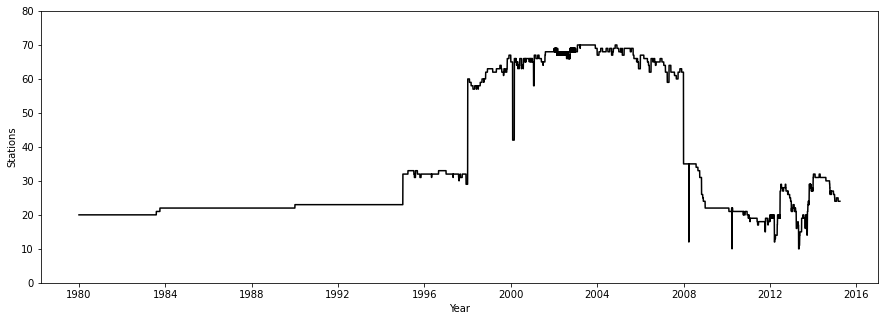

In [10]:
plt.figure(figsize=(15,5))
plt.plot(dff['Date'],dff['Prec'], 'k')
plt.xlabel("Year")
plt.ylabel("Stations")
plt.yticks([0,10,20,30,40,50,60,70,80])
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(20,5))
for idx, r in enumerate(dfg.Region.unique()):
    x = dfg[dfg['Region']==r]['year']
    y = np.trunc(dfg[dfg['Region']==r]['Prec']/365)
    if idx == 0: ax.bar(x,y,label=r)
    else: ax.bar(x,y,label=r, bottom=y_old)
    y_old = y
plt.legend()
plt.grid()
plt.plot()

In [12]:
regions = df['Region'].unique()
df['diff'] = df['precip_norris'] - df['Prec']
df['ae'] = abs(df['diff'])

for r in regions: 
    average = df['ae'][df['Region']==r].mean()
    print(r, f'{average:.2f}')

for r in regions:
    x = df[df['Region']==r]
    y = x['ae'][x['ae']!=0]
    print(r, f'{y.median():.2f}')
#     plt.hist(y, bins=50, log=True)
#     plt.show()

WestUIB 2.80
Langtang 8.64
EastUIB 4.31
WestUIB 1.79
Langtang 7.59
EastUIB 3.00


In [13]:
df.groupby(['Region','season']).mean()['ae']

Region    season
EastUIB   AM         1.746577
          JFM        2.533155
          JJAS       9.463204
          OND        0.911146
Langtang  AM         5.963162
          JFM        3.318540
          JJAS      18.624849
          OND        2.811258
WestUIB   AM         3.666807
          JFM        3.420456
          JJAS       2.632369
          OND        1.833219
Name: ae, dtype: float64

In [14]:
for r in regions:
    total_p = df[df['Region']==r].groupby(['Station']).mean()['Prec'].mean()
    print(r, f'{total_p:.2f}', f'{total_p*365:.0f}') 

WestUIB 1.15 421
Langtang 2.26 824
EastUIB 3.27 1194


In [15]:
df_b = df.groupby(['Region','Station']).mean()[['Prec','precip_norris','Z','rain_norris','X','Y']].reset_index()

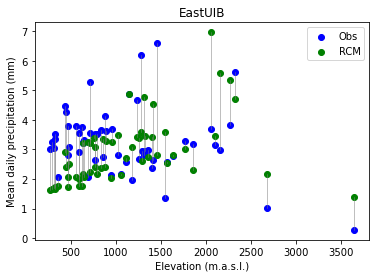

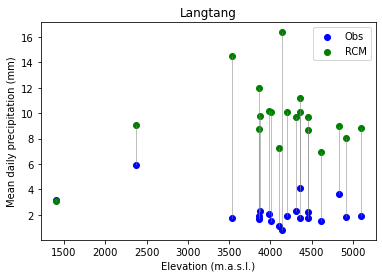

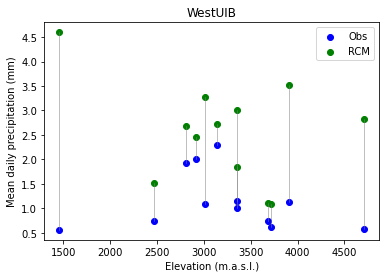

In [35]:
regions = df_b.Region.unique()

for r in regions:
    df_a = df_b[df_b['Region']==r]

    x = df_a['Z'].values
    y = df_a['Prec'].values
    y2 = df_a['precip_norris'].values
    y3 = df_a['rain_norris'].values
    
    xp = np.linspace(min(x),max(x),100)
    z = np.polyfit(x, y, 2)
    z2 = np.polyfit(x, y2, 2)
    z3 = np.polyfit(x, y3, 2)

    p = np.poly1d(z)
    p2 = np.poly1d(z2)
    p3 = np.poly1d(z3)
    
    plt.scatter(x,y,color='blue',label = 'Obs')
    plt.scatter(x,y2,color='green',label = 'RCM')
    
    for i in range(len(x)):
        plt.plot([x[i],x[i]*1,x[i]],[y[i],(y[i]+y2[i])/2,y2[i]],color='grey',linewidth=0.5)

#     plt.scatter(x,y3,color='orange', marker='x',label = 'RCM rain')
    
#     plt.plot(xp,p(xp),'b--')
#     plt.plot(xp,p2(xp),'g--')
#     plt.plot(xp,p3(xp),'--', color='orange')
    
    plt.ylabel('Mean daily precipitation (mm)')
    plt.xlabel('Elevation (m.a.s.l.)')
#     plt.grid()
    plt.legend()
    plt.title(r)
    plt.show()

In [16]:
import geopandas
import contextily as cx

In [17]:
gdf = geopandas.GeoDataFrame(df_b, geometry=geopandas.points_from_xy(df_b.X, df_b.Y), crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)

In [18]:
gdf['AE_precip'] = abs(gdf['Prec'] - gdf['precip_norris'])
gdf['E_precip'] = (gdf['Prec'] - gdf['precip_norris'])

/tmp/ipykernel_69918/1182552387.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([ax.get_yticks()])
/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/tmp/ipykernel_69918/1182552387.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([ax.get_yticks()])
/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/tmp/ipykernel_69918/1182552387.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([ax.get_yticks()])
/data/hpcdata/users/marron31/conda-envs/bcdp/l

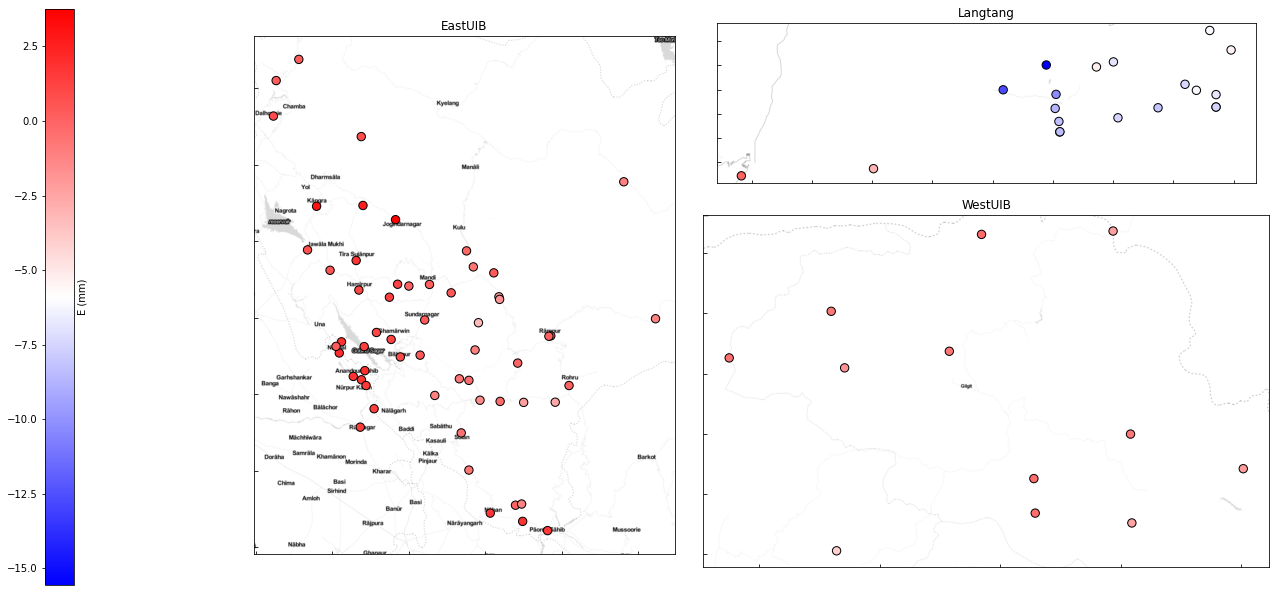

In [44]:
fig, axes  = plt.subplot_mosaic('ZAAAAABBBBBBB;ZAAAAACCCCCCC;ZAAAAACCCCCCC', figsize=(20,10))
frames = ['A','B','C']
# # Convert axes dictionary keys to actual Axes objects
# axes = {k: plt.subplot(v) for k, v in axes.items()}

for i,r in enumerate(gdf.Region.unique()):
    ax = axes[frames[i]]
    gdf1 = gdf[gdf['Region']==r]
    
    vmin = gdf['E_precip'].min()
    vmax = gdf['E_precip'].max()
    
    x = gdf1.geometry.x.values
    y = gdf1.geometry.y.values
    t = gdf1.Station.values
    
    # Color code points by elevation
    sc = ax.scatter(gdf1.geometry.x, gdf1.geometry.y, c=gdf1['E_precip'], cmap='bwr', edgecolor='k', vmin=vmin, vmax=vmax, s=70)
   
    if i==0:
        cbar = plt.colorbar(sc, label='E (mm)', cax=plt.gcf().add_axes([0.04, 0.1, 0.02, 0.8]))
        cbar.ax.yaxis.set_ticks_position('left') # Manually adjust the colorbar position
   
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, attribution=False)
#     cx.add_basemap(ax, source=cx.providers.Esri.WorldTopoMap, attribution=False)

    ax.tick_params(direction='in', which='both')
    ax.set_xticklabels([])
    ax.set_yticklabels([ax.get_yticks()])
    
#     for i, txt in enumerate(t):
#         ax.annotate(txt, (x[i]*1.0001, y[i]))
    
#     ax.tick_params(axis='x', pad=-15)
#     ax.tick_params(axis='x', pad=-20)
    ax.title.set_text(r)

ax = axes['Z']
ax.axis('off')

# plt.tight_layout()
# plt.savefig('AE_plot_TonerLite.png',dpi=300)
plt.show()